## Preliminaries

In [1]:
!rm -rf *.sh

<br>

### Packages

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/exhypotheses/beans/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

### Paths

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
else:
    notebooks = os.getcwd()
    parent = notebooks

<br>

Hence

In [6]:
warehouse = os.path.join(parent, 'warehouse', 'projections')
if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

### Libraries

In [7]:
import logging
import collections

import os

import yellowbrick.cluster

import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.utils

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<br>

### Logging

In [8]:
logging.basicConfig(level=logging.INFO, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [9]:
import config

import beans.graphics.relational
import beans.graphics.settings

import beans.functions.scalers

import beans.src.modelling

<br>

Configurations

In [10]:
configurations = config.Config()

<br>

Graphs

In [11]:
relational = beans.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [12]:
settings = beans.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

Constants

In [13]:
SEED = 5
np.random.seed(seed=SEED)

<br>
<br>

## Data

### Read

In [14]:
modelling = beans.src.modelling.Modelling()

In [15]:
data = modelling.data()

target = modelling.target
labels = modelling.labels

logger.info('Target field: {}'.format(target))
logger.info('\nLabels: {}'.format(labels))


Target field: class
2021-05-25 19:55:50.356

Labels: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
2021-05-25 19:55:50.360


<br>

### Weights

In [16]:
weight_values = sklearn.utils.class_weight.compute_class_weight(
    class_weight='balanced', classes=labels, y=data[target])
weight_values

array([1.47082343, 3.72495895, 1.19290096, 0.54834421, 1.00852104,
       0.95926422, 0.73764362])

In [17]:
weights = dict(zip(labels, weight_values))
weights

{'BARBUNYA': 1.4708234277069376,
 'BOMBAY': 3.72495894909688,
 'CALI': 1.1929009640666082,
 'DERMASON': 0.548344210780759,
 'HOROZ': 1.0085210432720806,
 'SEKER': 0.9592642187610121,
 'SIRA': 0.7376436158681986}

<br>
<br>

## Observations

In [18]:
x_data = data.drop(columns=target)
y_data = data[target]

<br>

### Scaling

In [19]:
scalers = beans.functions.scalers.Scalers()
scaler = scalers.determine(blob=x_data)

x_scaled = scalers.apply(blob=x_data, scaler=scaler)

scaled = pd.concat((x_scaled, y_data), axis=1, ignore_index=False)

<br>

### Elbow

Algorithm

In [20]:
kmc = sklearn.cluster.KMeans(random_state=SEED, max_iter=1000, algorithm='full')

<br>

Observations

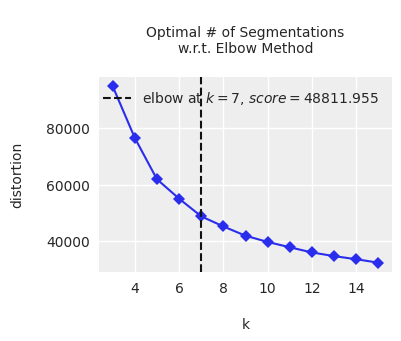

In [21]:
# Fit & Illustrate
ax = relational.figure(width=3.9, height=3.3)
ybc = yellowbrick.cluster.KElbowVisualizer(
    estimator=kmc, k=(3, 16), metric='distortion', timings=False, show=False, ax=ax);
ybc.fit(X=scaled.drop(columns=target))
relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nOptimal # of Segmentations\nw.r.t. Elbow Method\n', 
                                                        '\nk', 'distortion\n']))
ax.legend(loc='upper right', fontsize='small');


In [22]:
elbow = pd.DataFrame(data={'k': ybc.k_values_, 'distortion': ybc.k_scores_})
elbow.loc[:, 'elbow_point'] = (elbow['k'] == ybc.elbow_value_).astype(np.int)

logger.info(elbow.info())

NumExpr defaulting to 2 threads.
2021-05-25 19:56:06.602
None
2021-05-25 19:56:06.615


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   k            13 non-null     int64  
 1   distortion   13 non-null     float64
 2   elbow_point  13 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 440.0 bytes


In [23]:
elbow.to_csv(path_or_buf=os.path.join(warehouse, 'elbow.csv'), 
             index=False, header=True, encoding='utf-8')

<br>
<br>

## Projecting

### t-SNE


* `ax.set_xticks(ticks=[-150, -100, -50, 0, 50, 100])`

Algorithm

In [24]:
sne = sklearn.manifold.TSNE(
    n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, 
    n_iter=1000, n_iter_without_progress=500, metric='cosine', init='pca', random_state=SEED, method='exact'
)

In [ ]:
transformation = sne.fit_transform(X=scaled.drop(columns=target))

<br>

Projections


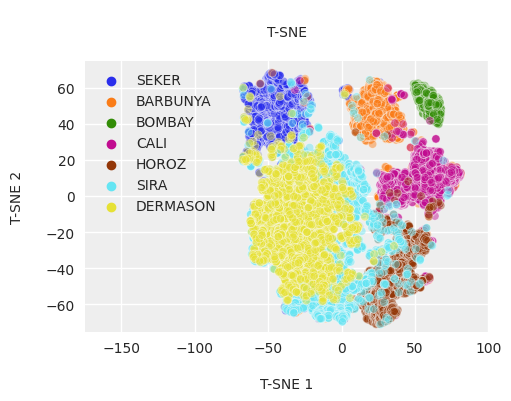

In [26]:
projections = pd.concat((pd.DataFrame(data=transformation, columns=['tsne_1', 'tsne_2']), scaled[target]), axis=1)

ax = relational.figure(width=5.0, height=3.9)
sns.scatterplot(data=projections, x='tsne_1', y='tsne_2', hue=target, alpha=0.45, ax=ax)

ax.set(xlim=(-175, 100), ylim=(-75, 75))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nT-SNE\n', 
                                                        '\nT-SNE 1', 'T-SNE 2\n']))
ax.legend(loc='upper left', fontsize='small'); 
    

In [34]:
projections.to_csv(path_or_buf=os.path.join(warehouse, 'tSNE.csv'), 
                   index=False, header=True, encoding='utf-8')

<br>

### PCA

Algorithm

In [27]:
kpca_ = sklearn.decomposition.KernelPCA(kernel='cosine')

In [30]:
kpca = kpca_.fit(X=scaled.drop(columns=target))
principals = kpca.transform(scaled.drop(columns=target))

<br>

Projections


Matrix Shape: (13611, 17), # of non-zero eigenvalues: 16
2021-05-25 22:10:32.977


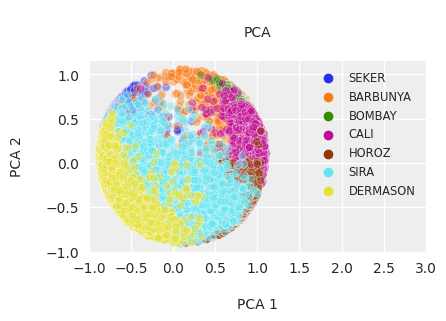

In [50]:
names = ['pca_' + str(i).zfill(2) for i in range(1, 1 + principals.shape[1])]
space = pd.concat((pd.DataFrame(data=principals, columns=names), scaled[target]), axis=1)
logger.info('\nMatrix Shape: {}, # of non-zero eigenvalues: {}'\
            .format(scaled.shape, kpca.lambdas_.shape[0]))

ax = relational.figure(width=4.35, height=3.1)
sns.scatterplot(data=space, x='pca_01', y='pca_02', hue=target, alpha=0.45, ax=ax)

ax.set(xlim=(-1.0, 3.0), ylim=(-1.0, 1.15))

relational.annotation(handle=ax, 
                    labels=RelationalGraphLabels._make(['\nPCA\n', '\nPCA 1', 'PCA 2\n']))
ax.legend(loc='upper right', fontsize='x-small'); 


In [51]:
space.to_csv(path_or_buf=os.path.join(warehouse, 'PCA.csv'), 
                   index=False, header=True, encoding='utf-8')

In [52]:
kpca.lambdas_

array([6.96663082e+03, 2.96526045e+03, 1.43471111e+03, 1.08621598e+03,
       4.97762598e+02, 1.82024775e+02, 1.26326183e+02, 4.87558833e+01,
       5.51343165e+00, 8.99387374e-01, 7.19612244e-01, 2.04893039e-01,
       7.17480740e-02, 2.87790195e-03, 1.35381554e-03, 8.81177273e-04])